# Land Cover Classification of Satellite Images

For this project, we are using satellite images from [EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://zenodo.org/record/7711810#.ZCtEhOzMJQK).

This dataset contains 27,000 RGB Satellite Images across 10 classes: 
- Annual Crop
- Forest
- Herbaceous Vegetation
- Highway
- Industrial
- Pasture
- Permanent Crop
- Residential
- River
- Sea or Lake <br><br>

There are about 2,500 images per class.

In [1]:
!git clone https://github.com/samson6460/tf_keras_gradcamplusplus.git ./assets/tf_keras_gradcamplusplus

Cloning into './assets/tf_keras_gradcamplusplus'...


In [3]:
import os, shutil
from PIL import Image
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimage
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay


from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.data.experimental import cardinality
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.applications import ResNet50, VGG19, VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from assets.tf_keras_gradcamplusplus.utils import preprocess_image
from assets.tf_keras_gradcamplusplus.gradcam import grad_cam, grad_cam_plus
from assets.tf_keras_gradcamplusplus.utils import preprocess_image
import tensorflow as tf
import cv2

In [4]:
train_folder = 'data/split/train'
test_folder = 'data/split/test'

train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18900 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [5]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [6]:
train_classes = train_generator.classes
train_class_names = train_generator.class_indices
val_classes = val_generator.classes
val_class_names = val_generator.class_indices
test_classes = test_generator.classes
test_class_names = test_generator.class_indices

train_class, train_count = np.unique(train_classes, return_counts=True)
val_class, val_count = np.unique(val_classes, return_counts=True)
test_class, test_count = np.unique(test_classes, return_counts=True)

print('Train')
print([i for i in zip(train_class_names, train_class, train_count)])
print('Validation')
print([i for i in zip(val_class_names, val_class, val_count)])
print('Test')
print([i for i in zip(test_class_names, test_class, test_count)])

Train
[('AnnualCrop', 0, 2100), ('Forest', 1, 2100), ('HerbaceousVegetation', 2, 2100), ('Highway', 3, 1750), ('Industrial', 4, 1750), ('Pasture', 5, 1400), ('PermanentCrop', 6, 1750), ('Residential', 7, 2100), ('River', 8, 1750), ('SeaLake', 9, 2100)]
Validation
[('AnnualCrop', 0, 300), ('Forest', 1, 300), ('HerbaceousVegetation', 2, 300), ('Highway', 3, 250), ('Industrial', 4, 250), ('Pasture', 5, 200), ('PermanentCrop', 6, 250), ('Residential', 7, 300), ('River', 8, 250), ('SeaLake', 9, 300)]
Test
[('AnnualCrop', 0, 600), ('Forest', 1, 600), ('HerbaceousVegetation', 2, 600), ('Highway', 3, 500), ('Industrial', 4, 500), ('Pasture', 5, 400), ('PermanentCrop', 6, 500), ('Residential', 7, 600), ('River', 8, 500), ('SeaLake', 9, 600)]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


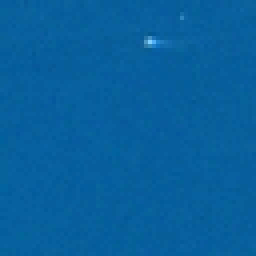

In [7]:
print(train_labels[0])
array_to_img(train_images[0])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


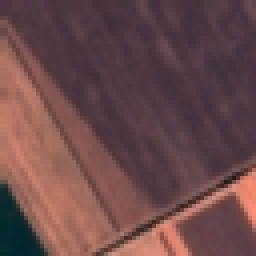

In [8]:
print(test_labels[0])
array_to_img(test_images[0])

## Implementing Cutom CNN Model

For our first model, we will be implementing a Simple Sequential Convolutional Neural Network. We will then train & test the model on our dataset to establish the performance of a custom CNN model for the task which will later be used for the comparison.

In [24]:
Custom_model = Sequential()

Custom_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape= (256, 256, 3)))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))
Custom_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))
Custom_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))
Custom_model.add(Flatten())
Custom_model.add(Dense(128, activation='relu'))
Custom_model.add(Dense(64, activation='relu'))
Custom_model.add(Dense(32, activation='relu'))
Custom_model.add(Dense(10, activation='softmax'))

Custom_model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

Custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)      

## Training Model

In [25]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 3)

Custom_history = Custom_model.fit(train_generator,
                                  epochs = 20, batch_size = 128, callbacks = valcallback,
                                  verbose = 1, validation_data = val_generator)

Epoch 1/20
148/148 [==============================] - 27s 172ms/step - loss: 1.6268 - accuracy: 0.3715 - val_loss: 1.3009 - val_accuracy: 0.5015
Epoch 2/20
148/148 [==============================] - 25s 167ms/step - loss: 1.1542 - accuracy: 0.5679 - val_loss: 1.0672 - val_accuracy: 0.6159
Epoch 3/20
148/148 [==============================] - 25s 167ms/step - loss: 0.9596 - accuracy: 0.6525 - val_loss: 0.9940 - val_accuracy: 0.6456
Epoch 4/20
148/148 [==============================] - 25s 171ms/step - loss: 0.7851 - accuracy: 0.7201 - val_loss: 0.7770 - val_accuracy: 0.7196
Epoch 5/20
148/148 [==============================] - 26s 173ms/step - loss: 0.6740 - accuracy: 0.7563 - val_loss: 0.6891 - val_accuracy: 0.7500
Epoch 6/20
148/148 [==============================] - 26s 176ms/step - loss: 0.5950 - accuracy: 0.7842 - val_loss: 0.6274 - val_accuracy: 0.7756
Epoch 7/20
148/148 [==============================] - 26s 177ms/step - loss: 0.5114 - accuracy: 0.8168 - val_loss: 0.5919 - val_ac

In [26]:
Custom_model.save('Custom_model.h5')

In [27]:
Training_history = Custom_history.history
json.dump(Training_history, open("./Custom_model_training.json", 'w'))

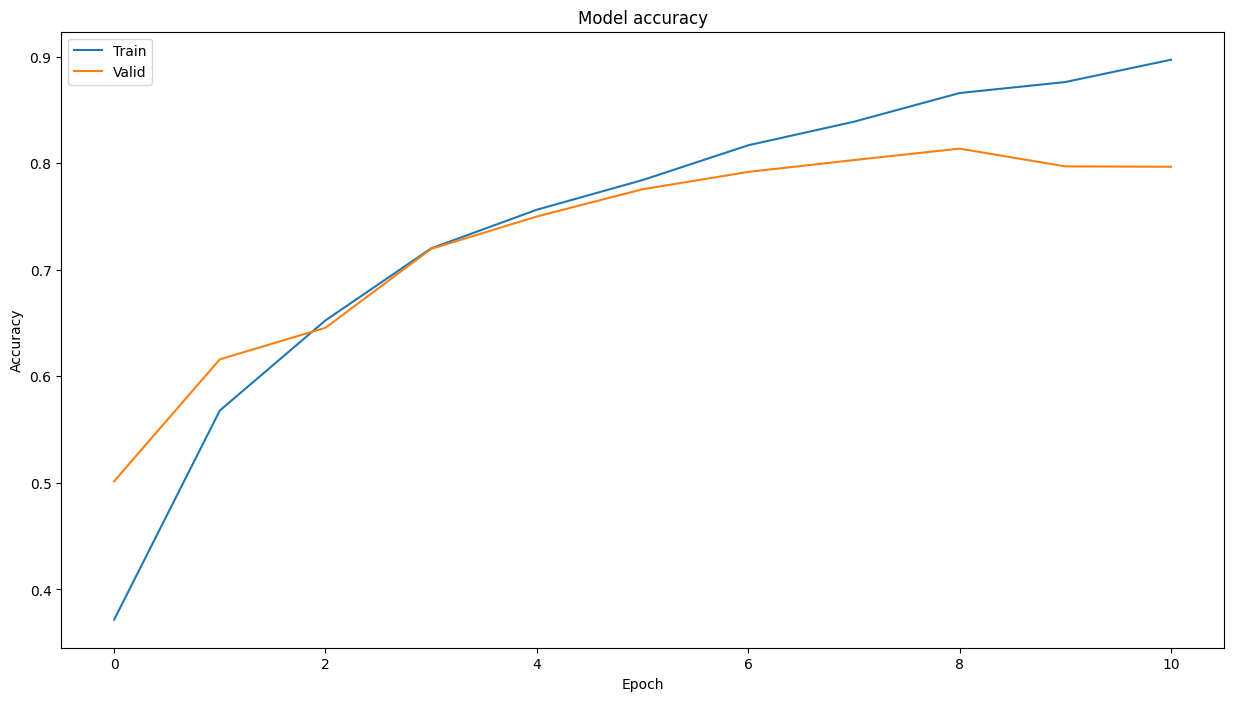

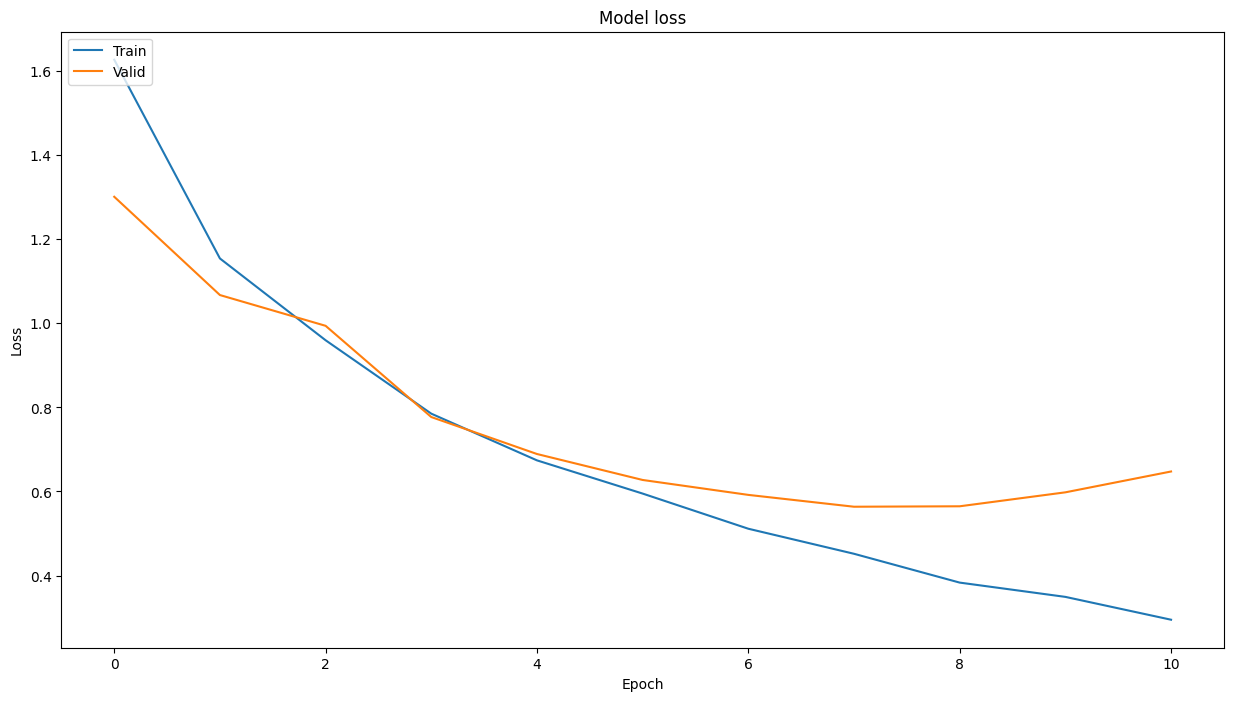

43/43 [==============================] - 6s 136ms/step


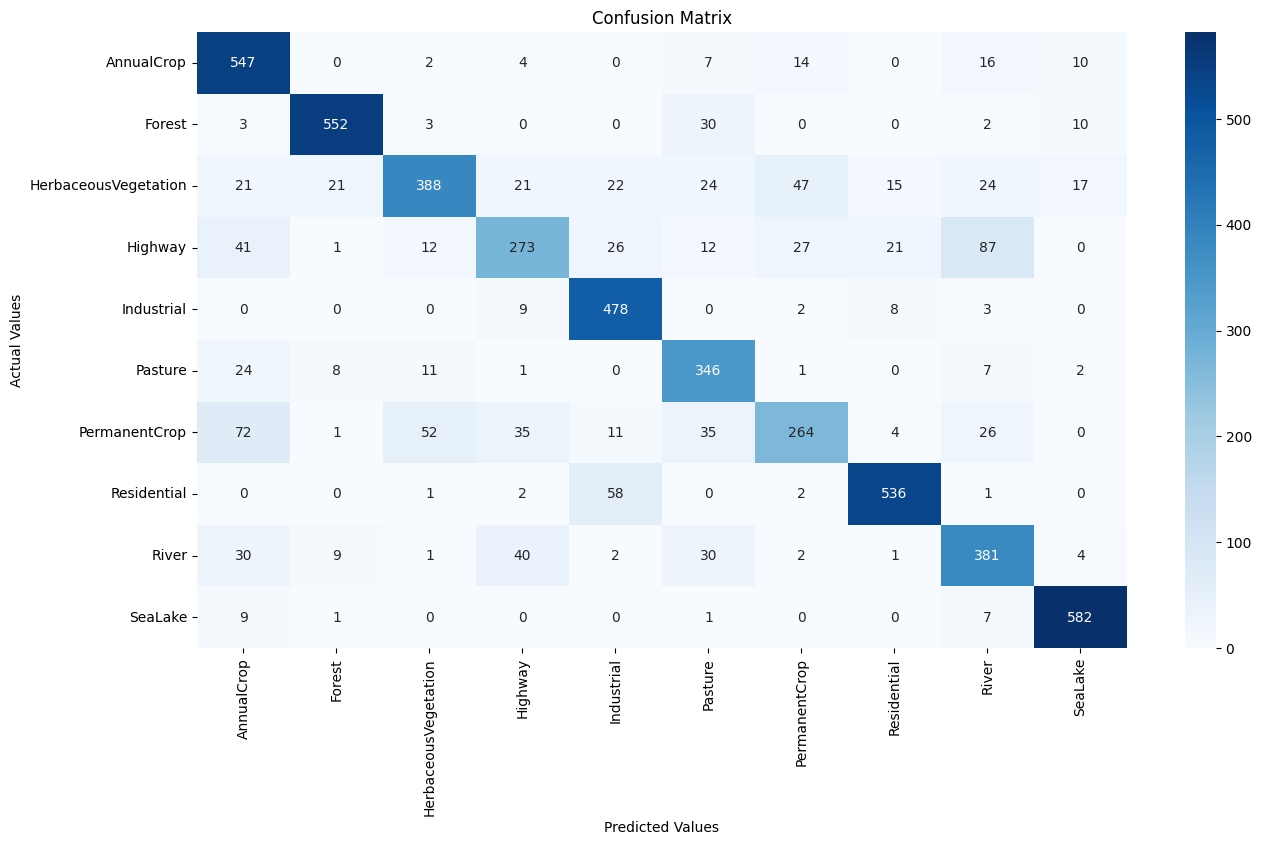

In [28]:
History = json.load(open("./Custom_model_training.json", 'r'))
plt.plot(History['accuracy'])
plt.plot(History['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

y_pred = Custom_model.predict(test_generator)

ax = sns.heatmap(confusion_matrix(test_generator.classes, y_pred.argmax(axis=1)), annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(test_class_names)
ax.yaxis.set_ticklabels(test_class_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Model Inference

In [29]:
def predict_class(file_path, model):
    img = load_img(file_path, target_size=(256,256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    
    predictions = model.predict(img_array)
    class_probabilities = predictions[0]
    predicted_class_index = np.argmax(class_probabilities)
    
    return list(test_class_names.keys())[predicted_class_index]

1/1 [==============================] - 0s 110ms/step
Highway


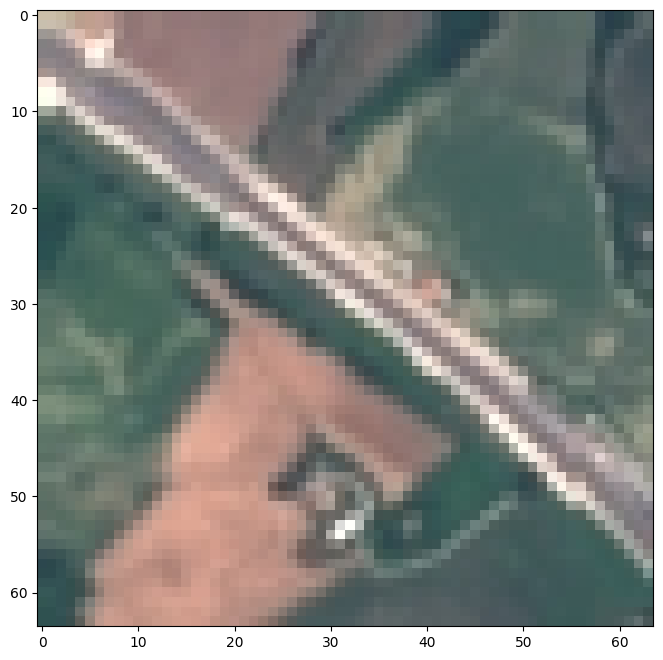

In [30]:
model = load_model('Custom_model.h5')
img_pth = "./data/split/test/Highway/Highway_1.jpg"
print(predict_class(img_pth,model))

plt.imshow(mpimage.imread(img_pth))
plt.show()


## XAI utils 

In [31]:
def path_to_image(image_path):
  img = Image.open(image_path)
  img = img.resize((256,256))    
  img = np.expand_dims(img, axis=0)
  return np.vstack([img])[0]

In [32]:
def show_img_with_heat(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img

In [46]:
def explain_image_grad_cam(img, model):
    image_path = './assets/buffer.jpg'  
    Image.fromarray(img).save(image_path)
    img = preprocess_image(image_path, target_size=(256, 256))
    heatmap = grad_cam(
        model, img,
        layer_name=model.layers[3].name,
    )
    img_arr = show_img_with_heat(image_path, heatmap)
    os.remove(image_path)
    
    return img_arr

In [43]:
def explain_image_grad_cam_plusplus(img, model):
    image_path = './assets/buffer.jpg'  
    Image.fromarray(img).save(image_path)
    img = preprocess_image(image_path, target_size=(256, 256))
    heatmap = grad_cam_plus(
        model, img,
        layer_name=model.layers[3].name,
    )
    img_arr = show_img_with_heat(image_path, heatmap)
    os.remove(image_path)
    
    return img_arr

## XAI function

In [44]:
def plot_XAI(img, model):
  plt.rcParams["figure.figsize"] = (10,10)
  fig, ax = plt.subplots(1,3)
  ax[0].imshow(img)
  ax[1].imshow(explain_image_grad_cam(img, model))
  ax[2].imshow(explain_image_grad_cam_plusplus(img, model))

  ax[0].set_title("Original Image")
  ax[1].set_title("Grad-CAM")
  ax[2].set_title("Grad-CAM++")

  fig.tight_layout()
  plt.show()
  plt.rcParams["figure.figsize"] = (15,8)

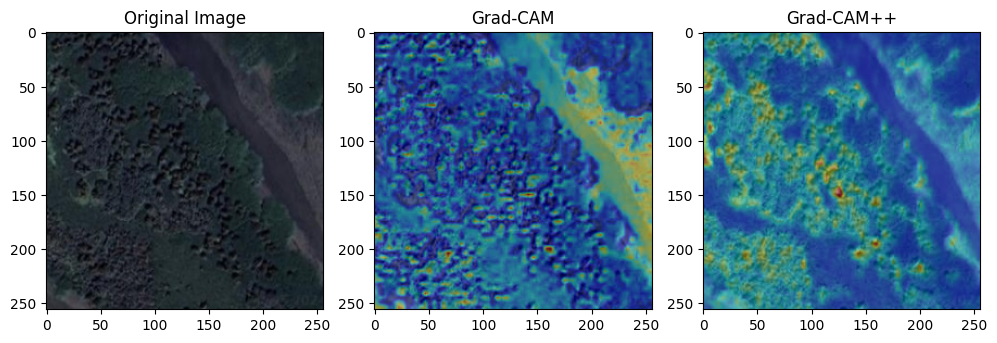

1/1 [==============================] - 0s 25ms/step


'HerbaceousVegetation'

In [47]:
img_p = "./Okhla_Bird_Sanc.jpg"
img = path_to_image(img_p)
plot_XAI(img, model)
predict_class(img_p, model)